<a href="https://colab.research.google.com/github/ancestor9/Gyeongbok-AI-study/blob/main/05_07_Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this chapter, we will explore the intuition behind SVMs and their use in classification problems.

We begin with the standard imports:

In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
from scipy import stats

## Motivating Support Vector Machines

As part of our discussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned about a simple kind of model that describes the distribution of each underlying class, and experimented with using it to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*. That is, rather than modeling each class, we will simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task in which the two classes of points are well separated (see the following figure):

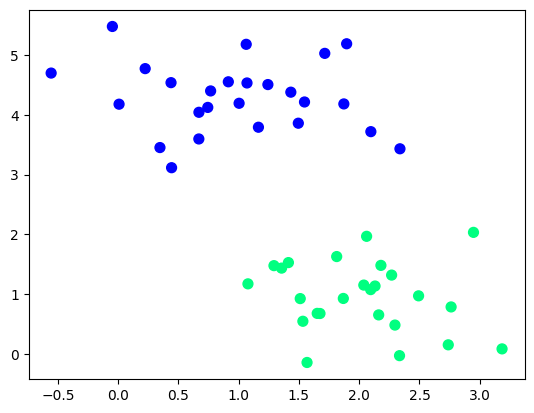

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two-dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw some of them as follows; the following figure shows the result:

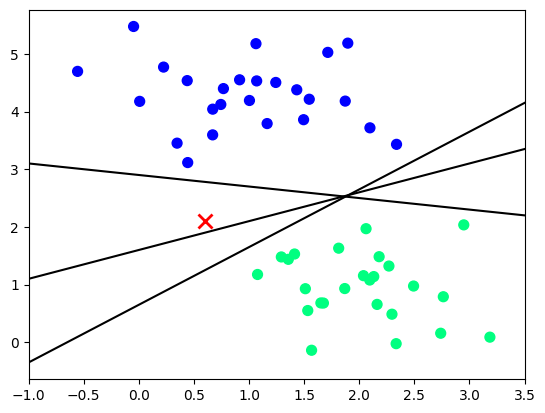

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not good enough, and we need to think a bit more deeply.

## Support Vector Machines: Maximizing the Margin

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look (see the following figure):

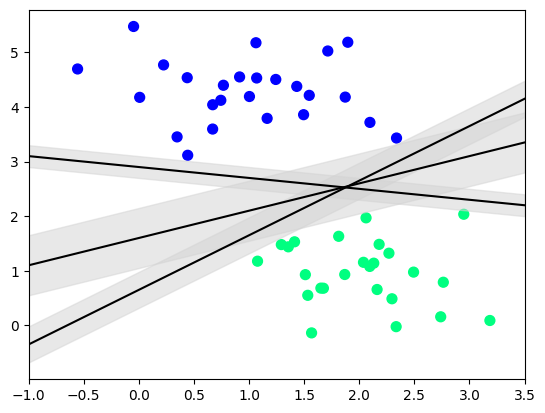

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

The line that maximizes this margin is the one we will choose as the optimal model.

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier (`SVC`) to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily):

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us (see the following figure):

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

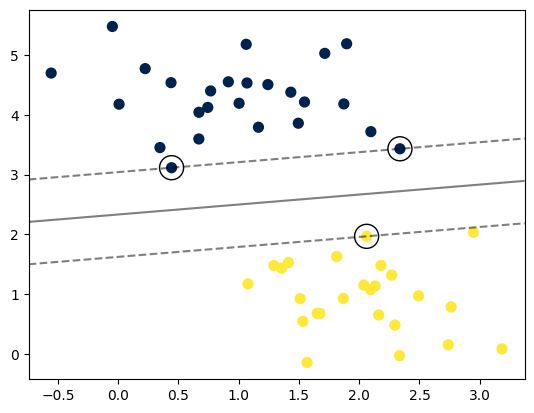

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='cividis')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are circled in the following figure.
These points are the pivotal elements of this fit; they are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identities of these points are stored in the `support_vectors_` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the positions of the support vectors matter; any points further from the margin that are on the correct side do not modify the fit.
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset (see the following figure):

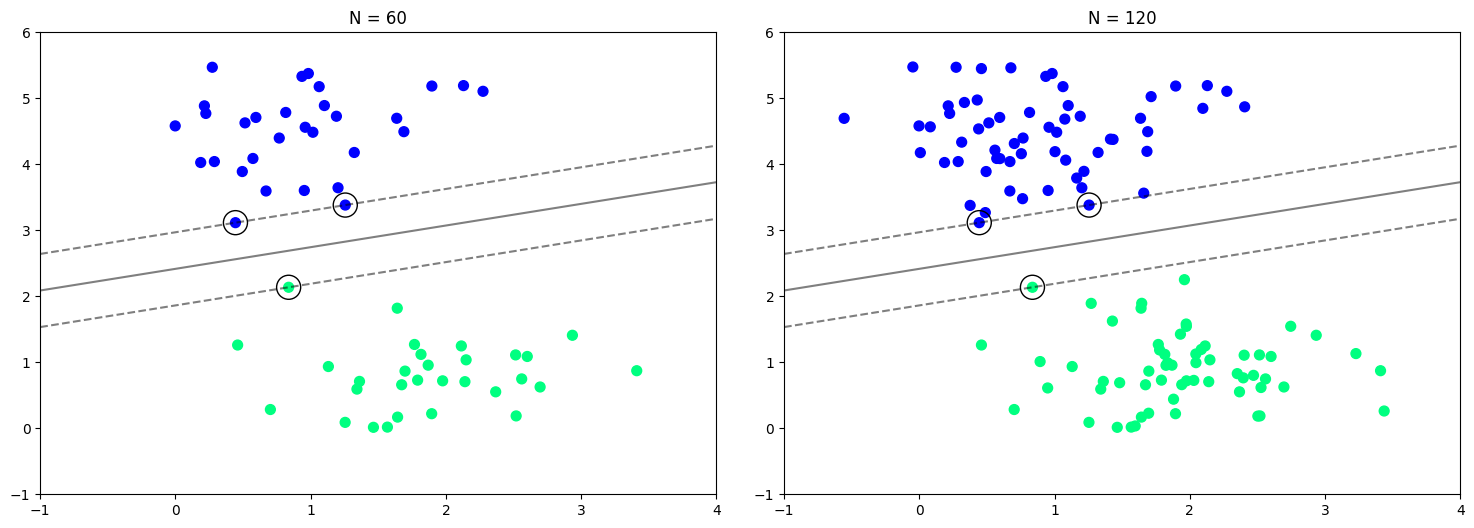

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors in the left panel are the same as the support vectors in the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

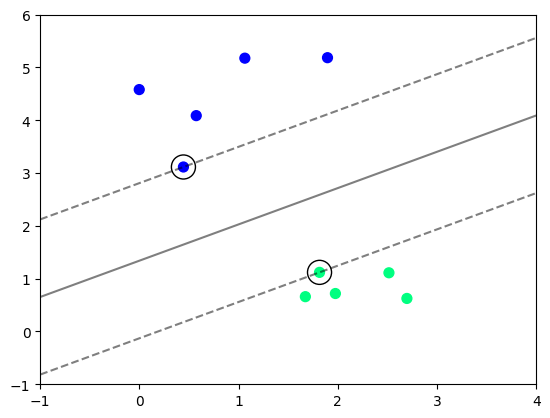

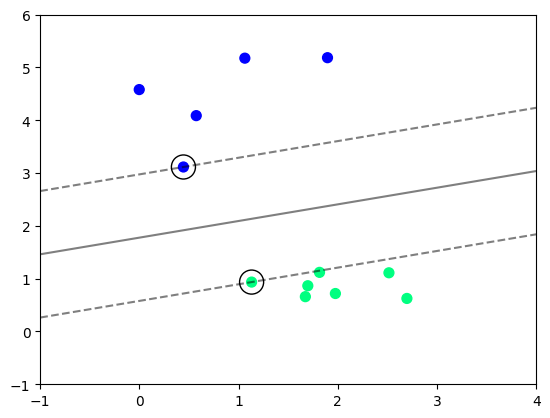

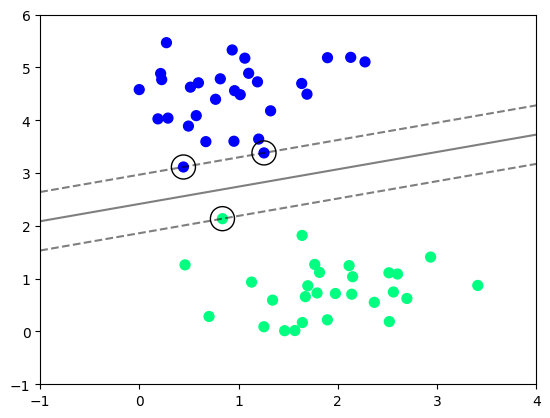

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=(10, 200), ax=fixed(None));

### Beyond Linear Boundaries: Kernel SVM

## **[Click to Support Vectors](https://github.com/ancestor9/2020_seminar/blob/main/20201022_04_SVC_DT.ipynb)**
### <font color='red'> **output [5]**


Where SVM can become quite powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into a higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable (see the following figure):

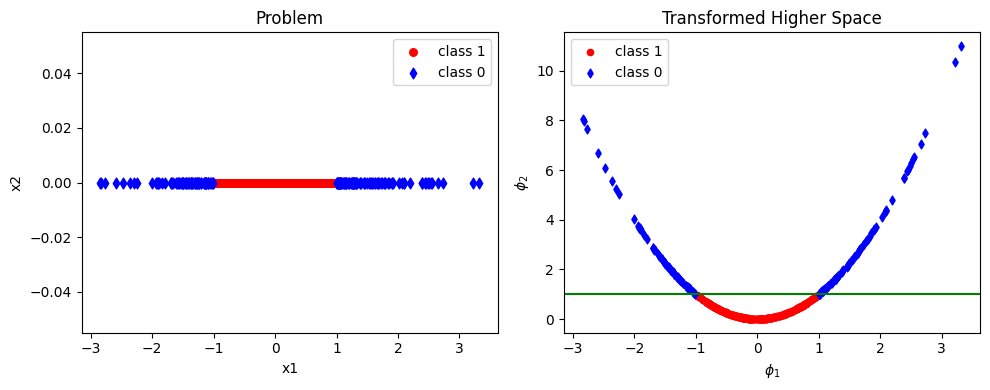

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
X = np.random.randn(500)
tr = 1
X_pos = X[np.logical_and(X < tr, X > -tr)]
X_neg = X[np.logical_or(X >= tr, X <= -tr)]

# 두 개의 그림을 한 줄에 배치
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 원본 공간에서의 분포
axes[0].scatter(X_pos, X_pos * 0, c='r', marker='o', label='class 1', s=30)
axes[0].scatter(X_neg, X_neg * 0, c='b', marker='d', label='class 0', s=30)
axes[0].legend()
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Problem')

# 변환된 공간에서의 분포
axes[1].scatter(X_pos, X_pos**2, c='r', marker='o', label='class 1', s=20)
axes[1].scatter(X_neg, X_neg**2, c='b', marker='d', label='class 0', s=20)
axes[1].axhline(y=tr, color='g', linestyle='-')
axes[1].legend()
axes[1].set_xlabel(r'$\phi_1$')
axes[1].set_ylabel(r'$\phi_2$')
axes[1].set_title('Transformed Higher Space')

plt.tight_layout()
plt.show()

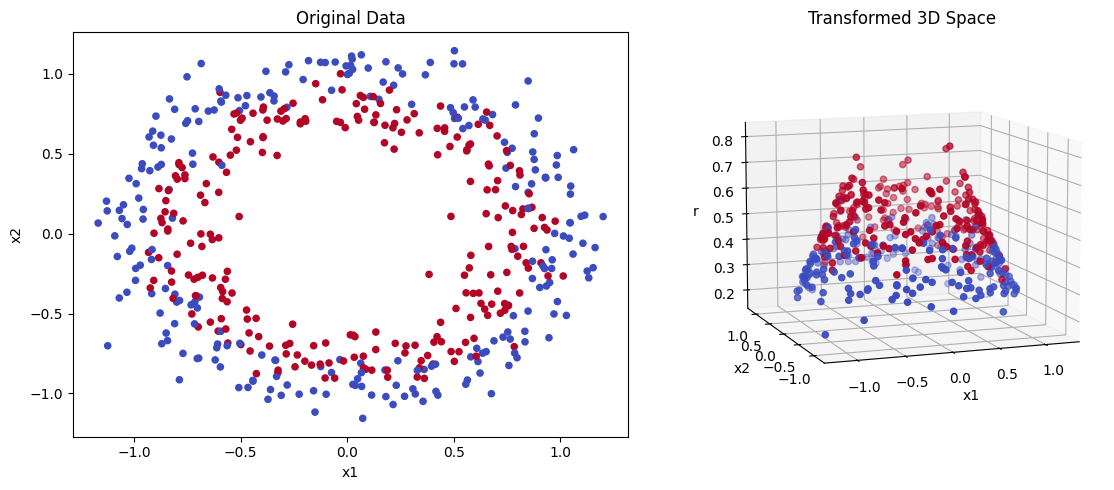

In [12]:
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D

# 데이터 생성
X, y = make_circles(n_samples=500, random_state=11, noise=0.1)

# 3D 변환
r = np.exp(-(X ** 2).sum(1))

# 두 개의 그림을 한 줄에 배치
fig = plt.figure(figsize=(12, 5))

# 2D Scatter Plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')
ax1.set_title("Original Data")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

# 3D Scatter Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter3D(X[:, 0], X[:, 1], r, c=y, cmap='coolwarm')
ax2.view_init(10, 250)
ax2.set_title("Transformed 3D Space")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("r")

plt.tight_layout()
plt.show()


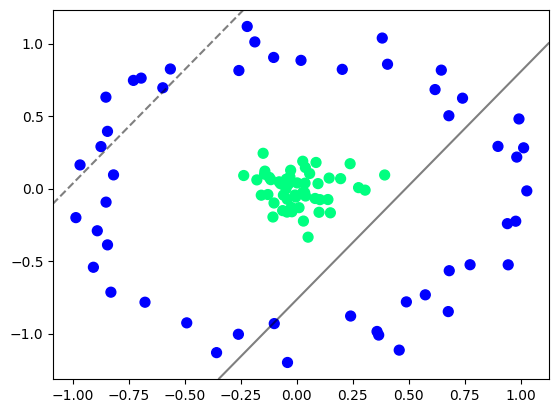

In [13]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* (RBF) centered on the middle clump:

In [14]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot, as seen in the following figure:

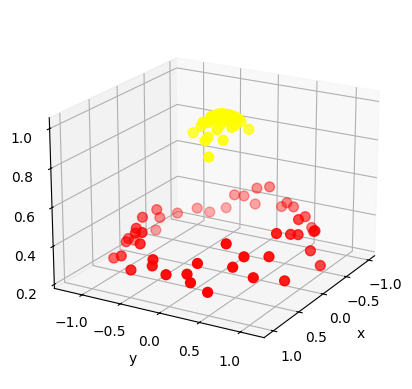

In [15]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

## Kernel Trick computaion, 내적의 합 kernel, 표준공분산도 커널의 일종

In [16]:
x = np.array([1,2,3])
y = np.array([4,5,6])

x_t = x.reshape(-1,1); x = x.reshape(1,-1)
q_x = x_t@x
q_x


array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [17]:

y_t = y.reshape(-1,1); y = y.reshape(1,-1)
q_y = y_t@y
q_y


array([[16, 20, 24],
       [20, 25, 30],
       [24, 30, 36]])

In [18]:

q_x * q_y
(q_x * q_y).sum()


1024

In [21]:
x = np.array([1,2,3]); y = np.array([4,5,6])
sum((x*y))**2 # kernel function
np.dot(x,y)**2

1024

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

In this case we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection.
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF kernel, using the `kernel` model hyperparameter:

In [25]:
# 자료 재 생성
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

Let's use our previously defined function to visualize the fit and identify the support vectors (see the following figure):

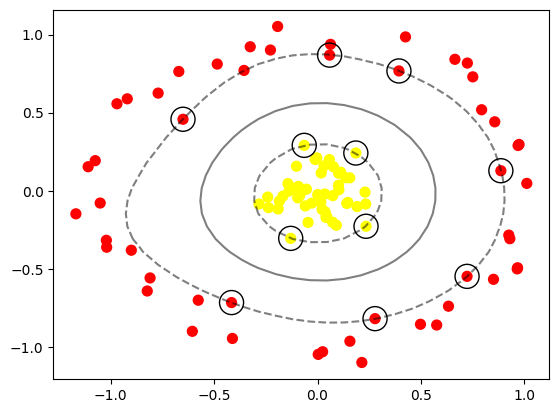

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

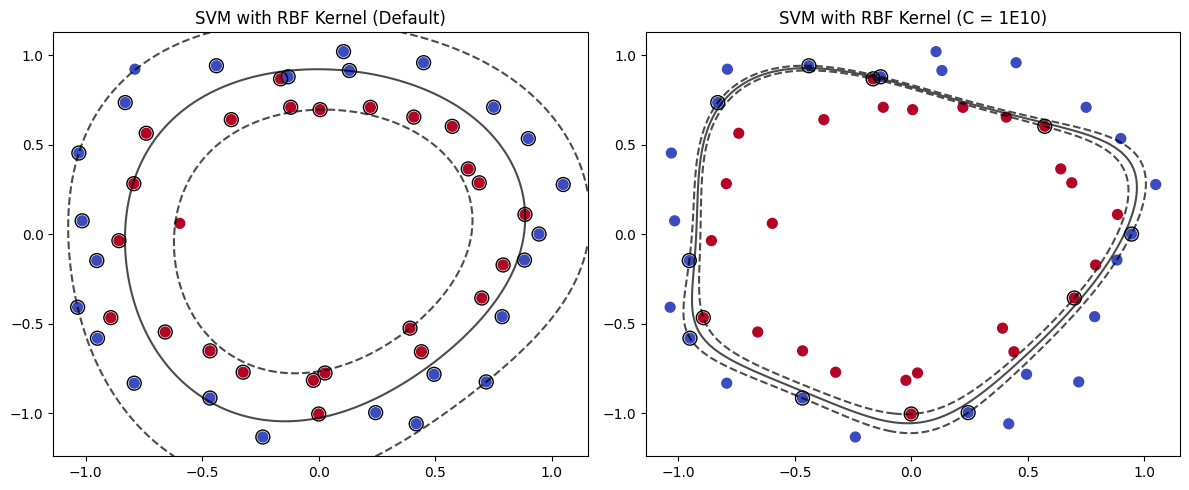

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_circles

# 데이터 생성
X, y = make_circles(n_samples=50, random_state=11, noise=0.1)

# 결정 경계 시각화 함수
def plot_svc_decision_function(model, ax):
    """SVM의 결정 경계를 그리는 함수"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # 그리드 생성
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 결정 경계와 마진
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.7,
               linestyles=['--', '-', '--'])
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=100, facecolors='none', edgecolors='k', label="Support Vectors")

# 두 개의 그림을 한 줄에 배치
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 첫 번째 SVM 모델 (기본 RBF)
model1 = SVC(kernel='rbf')
model1.fit(X, y)
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(model1, axes[0])
axes[0].set_title("SVM with RBF Kernel (Default)")

# 두 번째 SVM 모델 (C값 증가)
model2 = SVC(kernel='rbf', C=1E10)
model2.fit(X, y)
axes[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(model2, axes[1])
axes[1].set_title("SVM with RBF Kernel (C = 1E10)")

plt.tight_layout()
plt.show()




Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this (see the following figure):

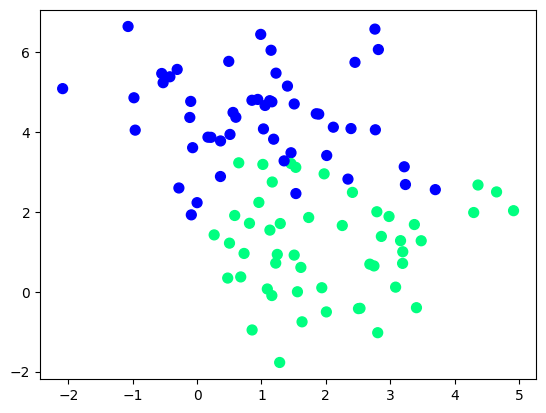

In [28]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

To handle this case, the SVM implementation has a bit of a fudge factor that "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as `C`.
For a very large `C`, the margin is hard, and points cannot lie in it.
For a smaller `C`, the margin is softer and can grow to encompass some points.

The plot shown in the following figure gives a visual picture of how a changing `C` affects the final fit via the softening of the margin:

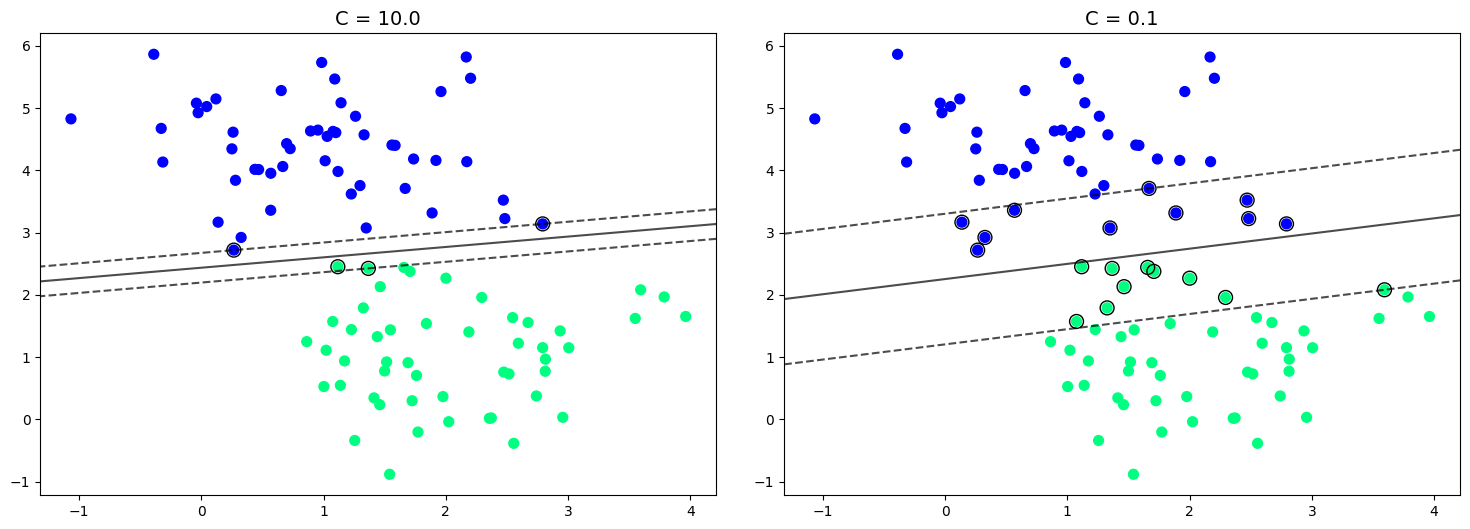

In [29]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of `C` will depend on your dataset, and you should tune this parameter using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

# <font color='orange'> **Why Scaled ? 자료표준화가 왜 머신러닝의 입력데이터 형태로 중요한가?**

### **[클릭_관련 소스코드](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb)**

In [30]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

(-2.0, 2.0, -2.0, 2.0)

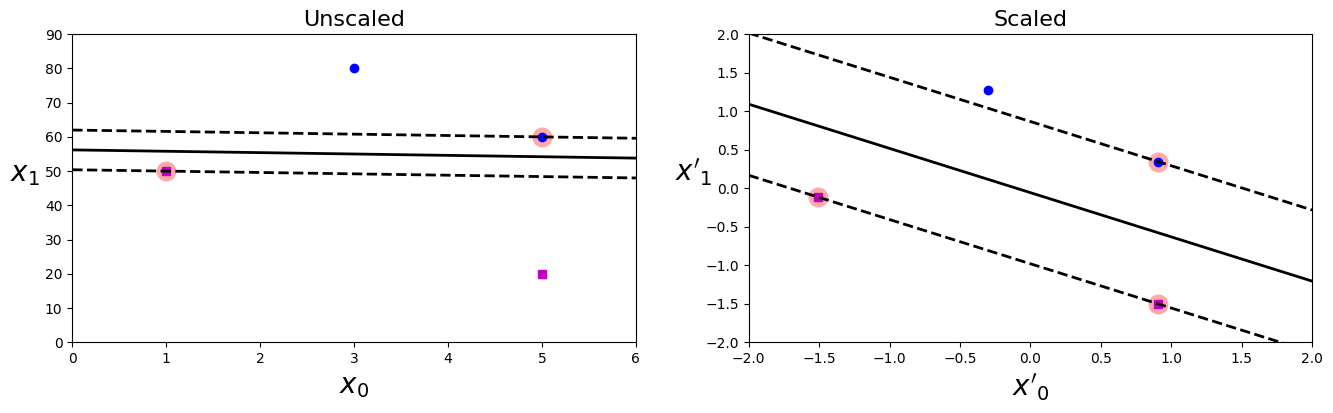

In [31]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

# **Linear Regression의 Basis Function(Gaussaian RBF)과 SVM의 RBF Kernel 관련성**
- x 가 0.5인 경우는 아마
- y = 0.95* 정규분포1 + 0.10*정규분포2 +................+ 0.0000001*마지막정규분포
- 아! x=0.5인 경우 첫번째 가우신안 분포와 가장 가깝구나, 첫번째 가우시안 분포에서 발생할 가능성이 가장 많겠구나...비슷하겠구나(Similarity)
- Simlarity는 거리가 가깝다는 것이구나

<img src = 'https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.06-gaussian-basis.png'>


# <font color='orange'>**Similarity Features**
- 가운데가 초록색 양 쪽 끝이 파란색인 직선을 이차함수 Kernel을 적용하여 2차원으로 Feature Representation을 만들어 직선으로 구분하는 대신 RBF를 적용하면 어떻게 될까? 결론은 동일하다.
## **Similarity features using the Gaussian RBF**
### gamma를 변경해보아라

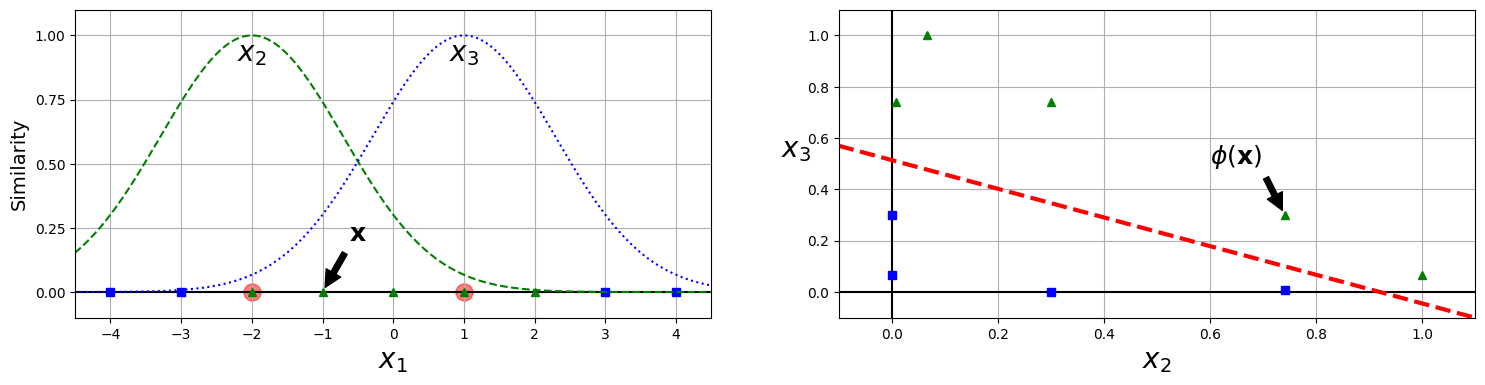

In [32]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])

plt.subplots_adjust(right=1)

plt.show()

### **위의 그림 설명**

In [33]:
x1_example = X1D[3, 0]
print(f'원래 자료 화살표의 점 x는 : {x1_example}\n\n')


x1_new_by_kernel = [ ]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]),
                     np.array([[landmark]]),
                     gamma)
    print(f"원래 자료 x: {x1_example}를 정규분포의 중심_평균_landmark {landmark})로 부터의 거리(Similarity)를 계산하면 {k}가 되고\n")
    x1_new_by_kernel.append(k[0])

print(f'원래 자료는 커널함수에 의해 새로운 차원(2차원)으로 날아가서 {x1_new_by_kernel}로 변환된다.')

원래 자료 화살표의 점 x는 : -1.0


원래 자료 x: -1.0를 정규분포의 중심_평균_landmark -2)로 부터의 거리(Similarity)를 계산하면 [0.74081822]가 되고

원래 자료 x: -1.0를 정규분포의 중심_평균_landmark 1)로 부터의 거리(Similarity)를 계산하면 [0.30119421]가 되고

원래 자료는 커널함수에 의해 새로운 차원(2차원)으로 날아가서 [0.7408182206817179, 0.30119421191220214]로 변환된다.


## **1. Generate Sample**
### **Nonlinear SVM Classification**
> ### **RBF 와 Polynomial**

In [34]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

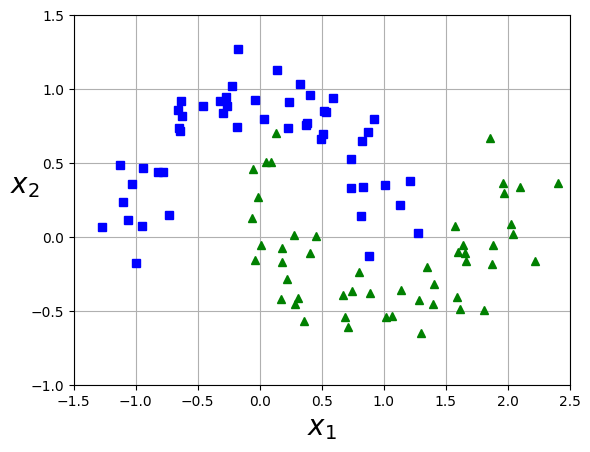

In [35]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## **2. SVM classifiers using an RBF kernel**

In [39]:
from sklearn.pipeline import Pipeline

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

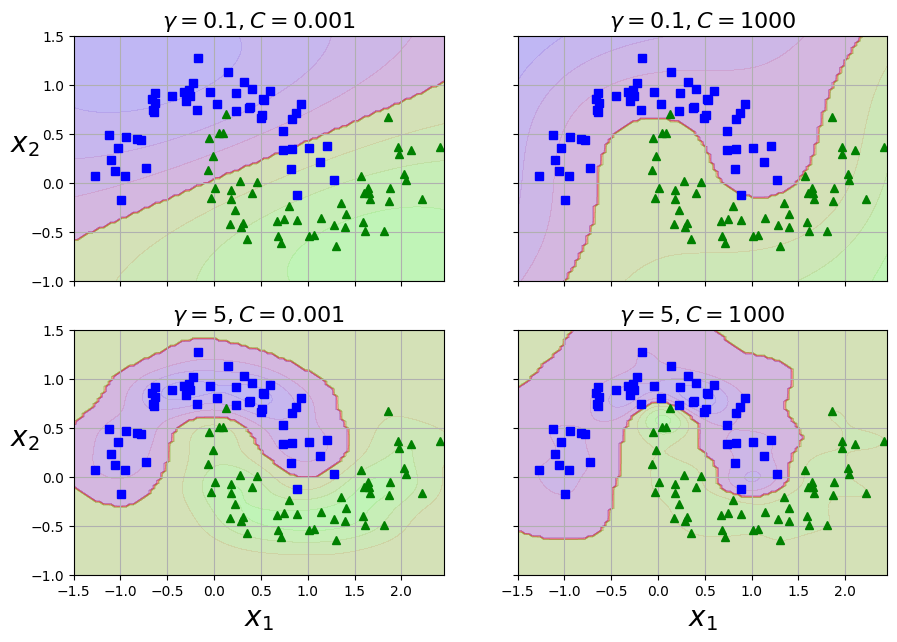

In [40]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
plt.show()

## **2. SVM classifiers using an Polynomial Kernel**

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

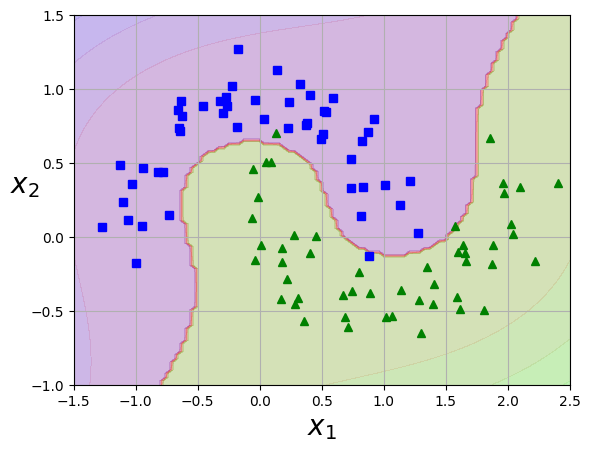

In [42]:

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [43]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with (see the following figure):

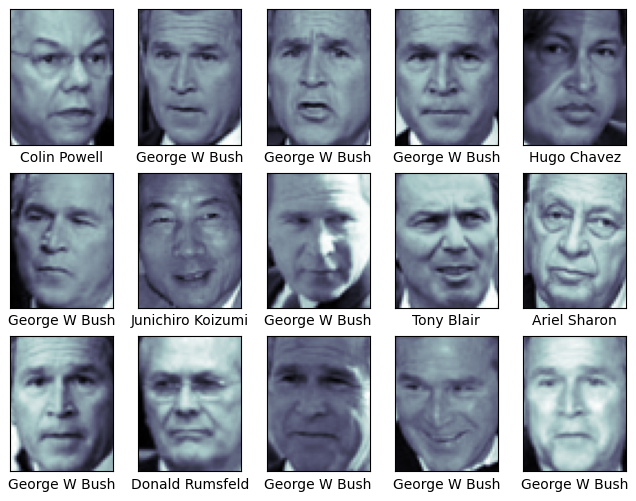

In [44]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains 62 × 47, or around 3,000, pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [45]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training set and a testing set:

In [46]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 26s, sys: 24.7 s, total: 1min 51s
Wall time: 1min 6s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model we can predict the labels for the test data, which the model has not yet seen:

In [48]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values (see the following figure):

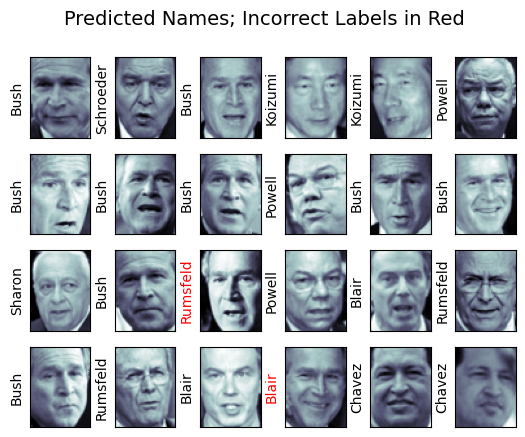

In [49]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [50]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes (see the following figure):

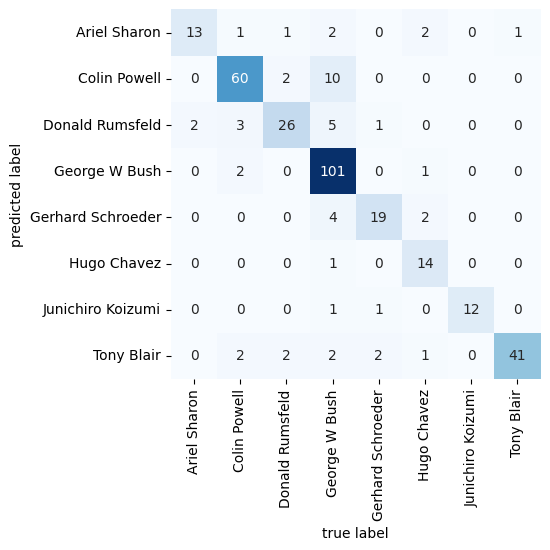

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pretrained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Summary

This has been a brief intuitive introduction to the principles behind support vector machines.
These models are a powerful classification method, for a number of reasons:

- Their dependence on relatively few support vectors means that they are compact and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter `C`. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the `probability` parameter of `SVC`), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.